<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/IntermediateDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Deep Learning

In [ ]:
%%bash
pip install --no-cache-dir -qU \
    lightning

## Training robust neural networks

In [ ]:
import os
os.makedirs("data", exist_ok=True)

In [ ]:
%%bash
cd ./data
unzip -qo water_potability.zip

Features shape: torch.Size([128, 9]),
Labels shape: torch.Size([128])


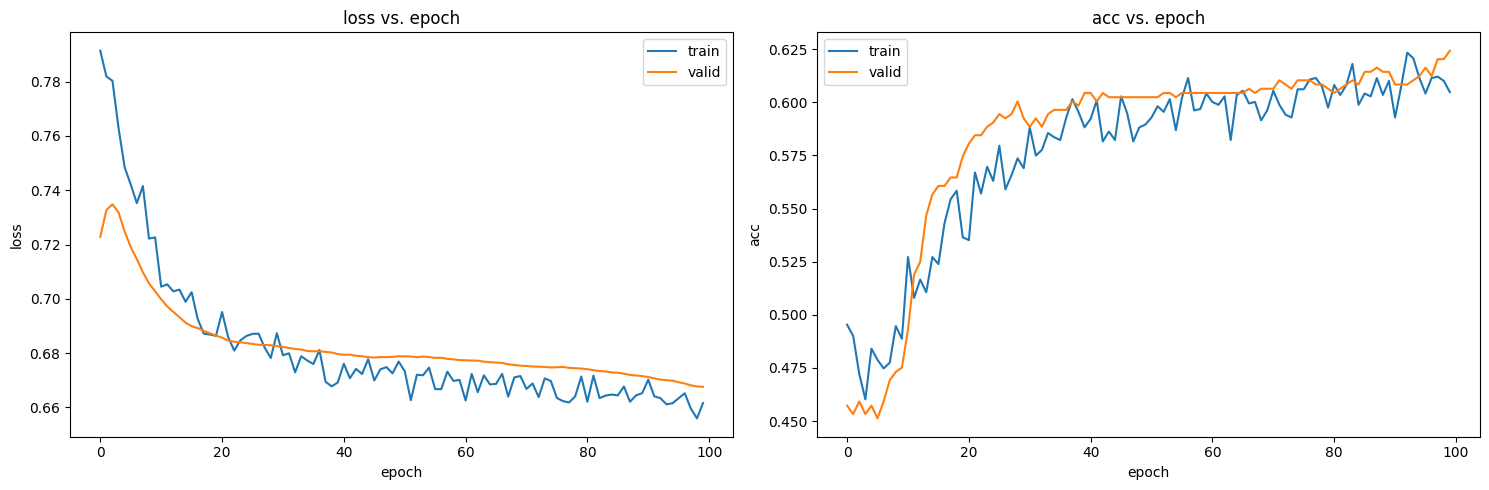

In [ ]:
import os
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import torch
torch.manual_seed(seed=42)
import torchmetrics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

class WaterDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy(dtype=np.float32)

    # Implement __len__ to return the number of data samples
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx, -1]
        return features, label

# Create an instance of the WaterDataset
dataset_train = WaterDataset("./data/water_potability/water_train.csv")
dataset_test = WaterDataset("./data/water_potability/water_test.csv")

# Create a DataLoader based on dataset_train
dataloader_train = torch.utils.data.DataLoader(
    dataset=dataset_train, batch_size=128, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(
    dataset=dataset_test, batch_size=32, shuffle=False)

# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
print(f"Features shape: {features.shape},\nLabels shape: {labels.shape}")

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the three linear layers, apply He initialization
        # Add two batch normalization layers
        self.fc1 = torch.nn.Linear(in_features=9, out_features=16)
        torch.nn.init.kaiming_uniform_(tensor=self.fc1.weight)
        self.bn1 = torch.nn.BatchNorm1d(num_features=16)

        self.fc2 = torch.nn.Linear(in_features=16, out_features=8)
        torch.nn.init.kaiming_uniform_(tensor=self.fc2.weight)
        self.bn2 = torch.nn.BatchNorm1d(num_features=8)

        self.fc3 = torch.nn.Linear(in_features=8, out_features=1)
        torch.nn.init.kaiming_uniform_(tensor=self.fc3.weight,
            nonlinearity="sigmoid")
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x):
        # Pass x through linear layers adding activations
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.nn.functional.elu(x)
        x = self.dropout(x)

        # Pass x through the second set of layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.nn.functional.elu(x)
        x = self.dropout(x)

        x = torch.nn.functional.sigmoid(self.fc3(x))
        return x

net = Net()
criterion = torch.nn.BCELoss()
# Define the Adam optimizer
optimizer = torch.optim.Adam(params=net.parameters(),
    lr=1e-3, weight_decay=1e-4)
# Set up binary accuracy metric
metric_acc = torchmetrics.Accuracy(task="binary")
if torch.cuda.is_available():
    net = net.cuda()
    metric_acc = metric_acc.cuda()

history = {
    "train_loss": [], "train_acc": [],
    "valid_loss": [], "valid_acc": []
}
for epoch in range(100):
    train_loss = 0.0
    for features, labels in dataloader_train:
        labels = labels.view(-1, 1)
        if torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        # Get predicted probabilities
        preds = net(features)
        metric_acc(preds=preds, target=labels)
        loss = criterion(input=preds, target=labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(dataloader_train)
    history["train_loss"].append(train_loss)
    # Compute total accuracy
    train_acc = metric_acc.compute().item()
    history["train_acc"].append(train_acc)
    metric_acc.reset()

    valid_loss = 0.0
    net.eval()
    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = labels.view(-1, 1)
            if torch.cuda.is_available():
                features = features.cuda()
                labels = labels.cuda()
            preds = net(features)
            metric_acc(preds=preds, target=labels)
            loss = criterion(input=preds, target=labels)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(dataloader_test)
        history["valid_loss"].append(valid_loss)
        valid_acc = metric_acc.compute().item()
        history["valid_acc"].append(valid_acc)
        metric_acc.reset()
    net.train()

df_history = pd.DataFrame(history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, m in zip(axes, ["loss", "acc"]):
    sns.lineplot(ax=ax, data=df_history, label="train",
        x=df_history.index, y=f"train_{m}")
    try:
        sns.lineplot(ax=ax, data=df_history, label="valid",
            x=df_history.index, y=f"valid_{m}")
    except Exception:
        pass
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

## Convolutional Neural Networks

In [ ]:
import os
os.makedirs("data", exist_ok=True)

In [ ]:
%%bash
cd ./data
unzip -qo clouds.zip

Images shape: torch.Size([16, 3, 64, 64]), 
Labels shape: torch.Size([16])


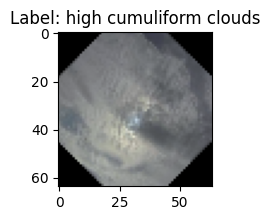

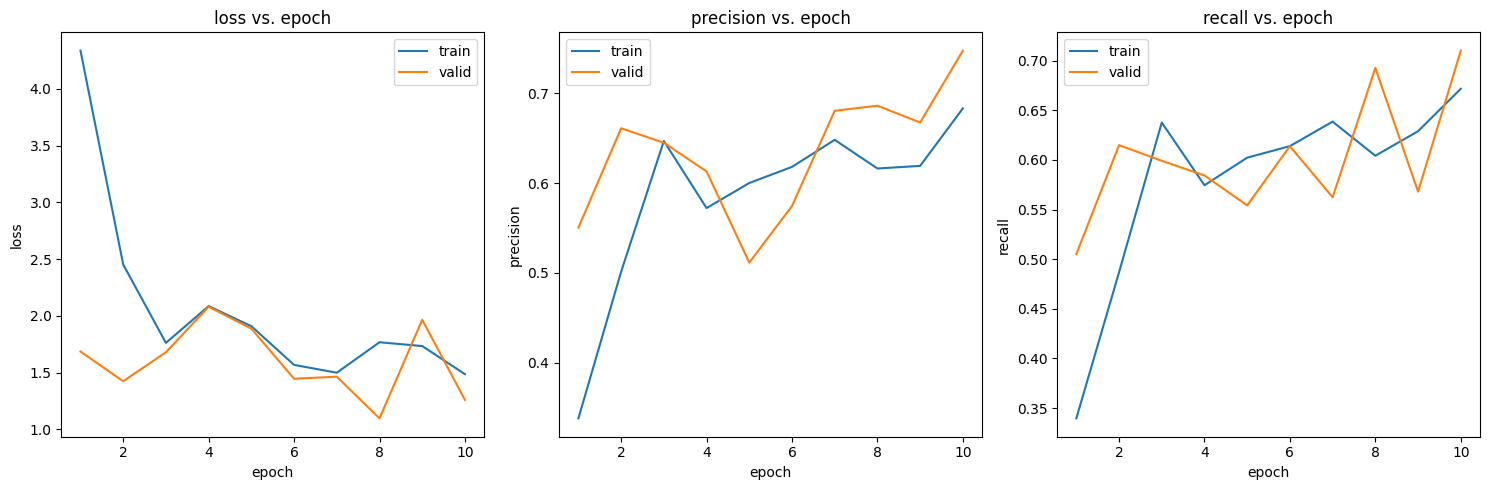

Valid precision per class: {'cirriform clouds': 0.6166666746139526, 'clear sky': 0.9117646813392639, 'cumulonimbus clouds': 0.7692307829856873, 'cumulus clouds': 0.5963855385780334, 'high cumuliform clouds': 0.574999988079071, 'stratiform clouds': 0.9714285731315613, 'stratocumulus clouds': 0.7916666865348816}
Valid recall per class: {'cirriform clouds': 0.48051947355270386, 'clear sky': 0.96875, 'cumulonimbus clouds': 0.9090909361839294, 'cumulus clouds': 0.824999988079071, 'high cumuliform clouds': 0.6699029207229614, 'stratiform clouds': 0.8500000238418579, 'stratocumulus clouds': 0.26760563254356384}


In [ ]:
import os
import pandas as pd
import torch
torch.manual_seed(seed=42)
import torchvision
import torchmetrics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Compose transformations
train_transforms = torchvision.transforms.Compose([
    # Add horizontal flip and rotation
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.RandomAutocontrast(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(64, 64)),
])
# Create Dataset using ImageFolder
dataset_train = torchvision.datasets.ImageFolder(
    root="./data/clouds/clouds_train", transform=train_transforms
)
dataloader_train = torch.utils.data.DataLoader(
  dataset=dataset_train, shuffle=True, batch_size=16
)

test_transforms = torchvision.transforms.Compose([
    # No data augmentation at test time
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(64, 64))
])
dataset_test = torchvision.datasets.ImageFolder(
    root="./data/clouds/clouds_test", transform=test_transforms
)
dataloader_test = torch.utils.data.DataLoader(
    dataset=dataset_test, shuffle=False, batch_size=16
)

images, labels = next(iter(dataloader_train))
print(f"Images shape: {images.shape}, \nLabels shape: {labels.shape}")
# Reshape the image tensor
image = images[-1].squeeze().permute(1, 2, 0)
# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(image)
label = [k for k, v in dataset_train.class_to_idx.items()
    if v==labels[-1]][0]
plt.title(label=f"Label: {label}")
plt.show()

class Net(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32,
                kernel_size=(3, 3), padding=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),

            torch.nn.Conv2d(in_channels=32, out_channels=64,
                kernel_size=(3, 3), padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),
            torch.nn.Flatten(),
        )
        torch.nn.init.kaiming_uniform_(tensor=self.feature_extractor[0].weight)
        torch.nn.init.kaiming_uniform_(tensor=self.feature_extractor[4].weight)
        # Define classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(in_features=64*16*16, out_features=num_classes)
        )
        torch.nn.init.kaiming_uniform_(tensor=self.classifier[1].weight)

    def forward(self, x):
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        return self.classifier(x)

# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
# Define metrics
metric_precision = torchmetrics.Precision(
    task="multiclass", num_classes=7, average=None)
metric_recall = torchmetrics.Recall(
    task="multiclass", num_classes=7, average=None)

if torch.cuda.is_available():
    net = net.cuda()
    metric_precision = metric_precision.cuda()
    metric_recall = metric_recall.cuda()

history = {
    "train_loss": [], "train_precision": [], "train_recall": [],
    "valid_loss": [], "valid_precision": [], "valid_recall": []
}
for epoch in range(10):
    train_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        preds = net(images)
        metric_precision(preds=preds, target=labels)
        metric_recall(preds=preds, target=labels)
        loss = criterion(input=preds, target=labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(dataloader_train)
    history["train_loss"].append(train_loss)
    train_precision = metric_precision.compute()
    history["train_precision"].append(train_precision.mean().item())
    metric_precision.reset()
    train_recall = metric_recall.compute()
    history["train_recall"].append(train_recall.mean().item())
    metric_recall.reset()

    valid_loss = 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in dataloader_test:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            preds = net(images)
            metric_precision(preds=preds, target=labels)
            metric_recall(preds=preds, target=labels)
            loss = criterion(input=preds, target=labels)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(dataloader_test)
        history["valid_loss"].append(valid_loss)
        valid_precision = metric_precision.compute()
        history["valid_precision"].append(valid_precision.mean().item())
        metric_precision.reset()
        valid_recall = metric_recall.compute()
        history["valid_recall"].append(valid_recall.mean().item())
        metric_recall.reset()
    net.train()

df_history = pd.DataFrame(history)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, m in zip(axes, ["loss", "precision", "recall"]):
    sns.lineplot(ax=ax, data=df_history, label="train",
        x=df_history.index+1, y=f"train_{m}")
    try:
        sns.lineplot(ax=ax, data=df_history, label="valid",
            x=df_history.index+1, y=f"valid_{m}")
    except Exception:
        pass
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

# Get precision per class
valid_precision_per_class = {k: valid_precision[v].item()
    for k, v in dataset_test.class_to_idx.items()}
print("Valid precision per class:", valid_precision_per_class)

# Get recall per class
valid_recall_per_class = {k: valid_recall[v].item()
    for k, v in dataset_test.class_to_idx.items()}
print("Valid recall per class:", valid_recall_per_class)

## Recurrent Neural Networks

In [ ]:
import os
os.makedirs("data", exist_ok=True)

In [ ]:
%%bash
cd ./data
unzip -qo electricity_consump.zip

X_train shape: (105119, 96), y_train shape: (105119,)
X_test shape: (34944, 96), y_test shape: (34944,)
Features shape: torch.Size([32, 96]), Labels shape: torch.Size([32])


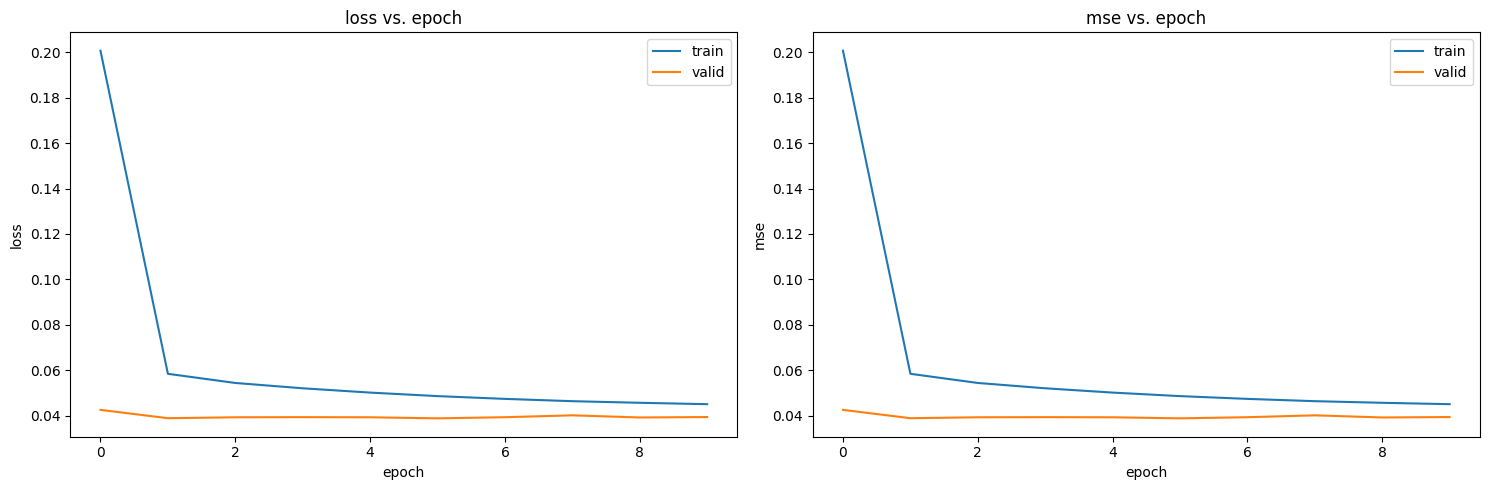

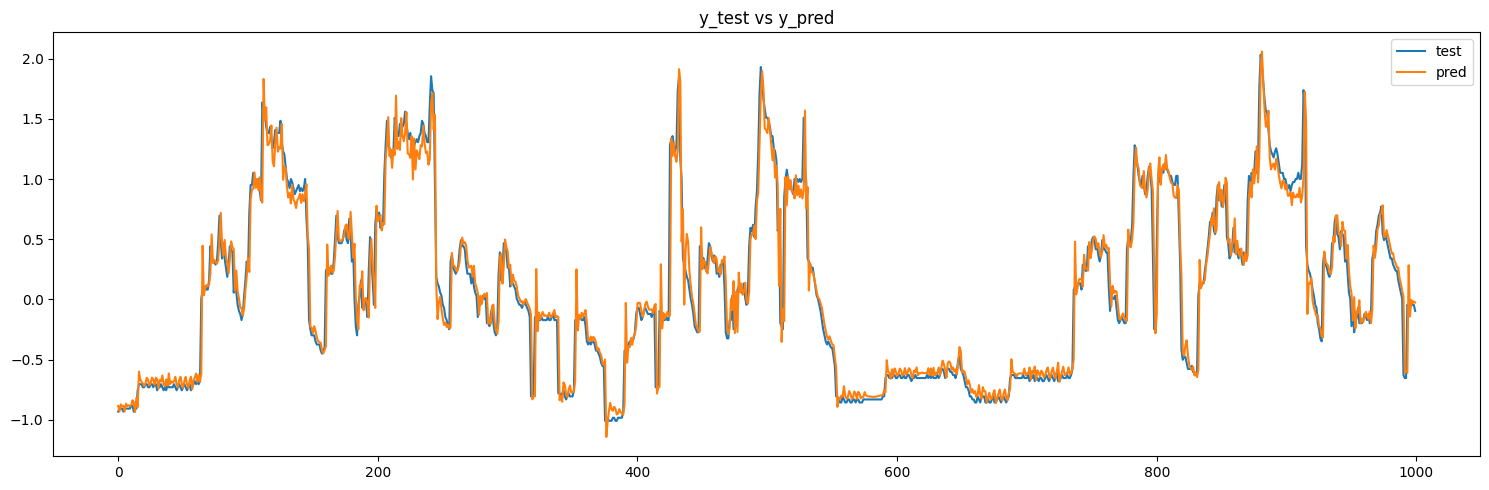

In [ ]:
import os
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import torch
torch.manual_seed(seed=42)
import torchmetrics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

seq_length = 24*4
batch_size = 32
input_dir = "./data/electricity_consump"

def create_sequences(csv_path, seq_length):
    df = pd.read_csv(csv_path)
    data = df["consumption"]
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = data[i:(i+seq_length)]
        # Define target
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Use create_sequences to create inputs and targets
X_train, y_train = create_sequences(
    csv_path=os.path.join(input_dir, "electricity_train.csv"),
    seq_length=seq_length)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_test, y_test = create_sequences(
    csv_path=os.path.join(input_dir, "electricity_test.csv"),
    seq_length=seq_length)
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Create TensorDataset
class ElectricConsumpDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset_train = ElectricConsumpDataset(X=X_train, y=y_train)
dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train,
    batch_size=batch_size, shuffle=True)

dataset_test = ElectricConsumpDataset(X=X_test, y=y_test)
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test,
    batch_size=batch_size, shuffle=False)

features, labels = next(iter(dataloader_train))
print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define LSTM layer
        self.lstm = torch.nn.LSTM(
            input_size=1, hidden_size=32,
            num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        # Initialize first hidden state with zeros
        h0 = torch.zeros(size=(2, x.size(0), 32))
        # Initialize long-term memory
        c0 = torch.zeros(size=(2, x.size(0), 32))
        if torch.cuda.is_available():
            h0 = h0.cuda()
            c0 = c0.cuda()
        # Pass x and h0 through recurrent layer
        out, _ = self.lstm(x, (h0, c0))
        # Pass recurrent layer's last output through linear layer
        out = self.fc(out[:, -1, :])
        return out

net = Net()
# Set up MSE loss
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-4)
# Define MSE metric
metric_mse = torchmetrics.MeanSquaredError()

if torch.cuda.is_available():
    net = net.cuda()
    metric_mse = metric_mse.cuda()

history = {
    "train_loss": [], "train_mse": [],
    "valid_loss": [], "valid_mse": []
}

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    for seqs, labels in dataloader_train:
        seqs = seqs.view(-1, seq_length, 1)
        if torch.cuda.is_available():
            seqs = seqs.cuda()
            labels = labels.cuda()
        # Get model outputs
        preds = net(seqs).squeeze()
        metric_mse(preds=preds, target=labels)
        # Compute loss
        optimizer.zero_grad()
        loss = criterion(input=preds, target=labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(dataloader_train)
    history["train_loss"].append(train_loss)
    train_mse = metric_mse.compute().item()
    history["train_mse"].append(train_mse)
    metric_mse.reset()

    valid_loss = 0.0
    net.eval()
    with torch.no_grad():
        for seqs, labels in dataloader_test:
            seqs = seqs.view(-1, seq_length, 1)
            if torch.cuda.is_available():
                seqs = seqs.cuda()
                labels = labels.cuda()
            # Pass seqs to net
            preds = net(seqs).squeeze()
            metric_mse(preds=preds, target=labels)
            loss = criterion(input=preds, target=labels)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(dataloader_test)
        history["valid_loss"].append(valid_loss)
        # Compute final metric value
        valid_mse = metric_mse.compute().item()
        history["valid_mse"].append(valid_mse)
        metric_mse.reset()
    net.train()

df_history = pd.DataFrame(history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, m in zip(axes, ["loss", "mse"]):
    sns.lineplot(ax=ax, data=df_history, label="train",
        x=df_history.index, y=f"train_{m}")
    try:
        sns.lineplot(ax=ax, data=df_history, label="valid",
            x=df_history.index, y=f"valid_{m}")
    except Exception:
        pass
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

y_pred = []
for seqs, _ in dataloader_test:
    seqs = seqs.view(-1, seq_length, 1)
    if torch.cuda.is_available():
        seqs = seqs.cuda()
    preds = net(seqs).data.cpu().numpy()
    y_pred.append(preds)
y_pred = np.array(y_pred).flatten()

plt.figure(figsize=(15, 5))
sns.lineplot(x=range(len(y_test[-1000:])), y=y_test[-1000:], label="test")
sns.lineplot(x=range(len(y_pred[-1000:])), y=y_pred[-1000:], label="pred")
plt.legend(loc="best")
plt.title(label="y_test vs y_pred")
plt.tight_layout()
plt.show()

## Multi-Input & Multi-Output

In [ ]:
import tensorflow_datasets as tfds

ds, info = tfds.load(name="omniglot", with_info=True)
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/19280 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/3.0.0.incompleteHWW281/omniglot-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/13180 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/3.0.0.incompleteHWW281/omniglot-test.tfrecord*...:   0%|         …

Generating small1 examples...:   0%|          | 0/2720 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/3.0.0.incompleteHWW281/omniglot-small1.tfrecord*...:   0%|       …

Generating small2 examples...:   0%|          | 0/3120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/3.0.0.incompleteHWW281/omniglot-small2.tfrecord*...:   0%|       …

Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='omniglot',
    full_name='omniglot/3.0.0',
    description="""
    Omniglot data set for one-shot learning. This dataset contains 1623 different
    handwritten characters from 50 different alphabets.
    """,
    homepage='https://github.com/brendenlake/omniglot/',
    data_dir=PosixGPath('/tmp/tmpnnyo_8_5tfds'),
    file_format=tfrecord,
    download_size=17.95 MiB,
    dataset_size=12.29 MiB,
    features=FeaturesDict({
        'alphabet': ClassLabel(shape=(), dtype=int64, num_classes=50),
        'alphabet_char_id': int64,
        'image': Image(shape=(105, 105, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=1623),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'small1': <SplitInfo num_examples=2720, num_shards=1>,
        'small2': <SplitInfo

Images shape: torch.Size([16, 3, 64, 64]), 
Alphabets shape: torch.Size([16, 50]),
Labels shape: torch.Size([16])


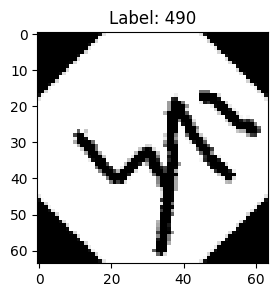

Alphabet: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


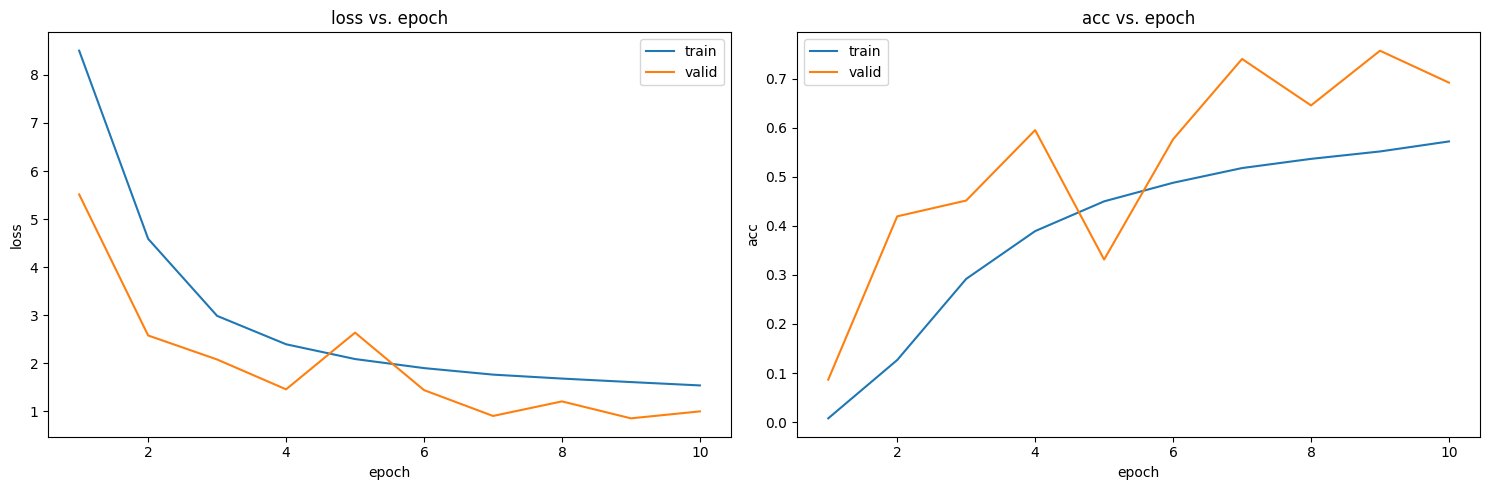

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import PIL
import torch
torch.manual_seed(seed=42)
import torchvision
import torchmetrics
import tensorflow_datasets as tfds
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

class OmniglotDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transforms):
        # Assign samples and transforms to class attributes
        self.samples = list(samples)
        self.transforms = transforms

    def __len__(self):
        # Return number of samples
        return len(self.samples)

    def __getitem__(self, idx):
        # Unpack the samples at index idx
        image = PIL.Image.fromarray(
            obj=self.samples[idx]["image"].numpy())
        image = self.transforms(image)
        alphabet = self.samples[idx]["alphabet"].numpy()
        alphabet = torch.nn.functional.one_hot(
            input=torch.tensor(alphabet), num_classes=50)
        label = self.samples[idx]["label"].numpy()
        return image, alphabet, label

# Transform the image
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.RandomAutocontrast(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(64, 64))
])
# Create dataset_train
dataset_train = OmniglotDataset(
    samples=tfds.load(name="omniglot", split="train+test"),
    transforms=train_transforms
)
# Create dataloader_train
dataloader_train = torch.utils.data.DataLoader(
    dataset=dataset_train, shuffle=True, batch_size=16
)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(64, 64))
])
# Create dataset_test
dataset_test = OmniglotDataset(
    samples=tfds.load(name="omniglot", split="small1+small2"),
    transforms=test_transforms
)
# Create dataloader_test
dataloader_test = torch.utils.data.DataLoader(
    dataset=dataset_test, shuffle=False, batch_size=16
)

images, alphabets, labels = next(iter(dataloader_train))
print(f"Images shape: {images.shape}, \nAlphabets shape: {alphabets.shape},\
\nLabels shape: {labels.shape}")
image = images[-1].squeeze().permute(1, 2, 0)
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.title(label=f"Label: {labels[-1]}")
plt.show()
print(f"Alphabet: {alphabets[-1]}")

class Net(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define sub-networks as sequential models
        self.image_layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32,
                kernel_size=(3, 3), padding=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),

            torch.nn.Conv2d(in_channels=32, out_channels=64,
                kernel_size=(3, 3), padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),

            torch.nn.Flatten(),
            torch.nn.Linear(in_features=64*16*16, out_features=128)
        )
        torch.nn.init.kaiming_uniform_(tensor=self.image_layer[0].weight)
        torch.nn.init.kaiming_uniform_(tensor=self.image_layer[4].weight)
        torch.nn.init.kaiming_uniform_(tensor=self.image_layer[9].weight)

        self.alphabet_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=50, out_features=10),
            torch.nn.ELU()
        )
        torch.nn.init.kaiming_uniform_(tensor=self.alphabet_layer[0].weight)

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(in_features=128+10, out_features=num_classes)
        )
        torch.nn.init.kaiming_uniform_(tensor=self.classifier[1].weight)

    def forward(self, x_image, x_alphabet):
        # Pass the x_image and x_alphabet through appropriate layers
        x_image = self.image_layer(x_image)
        x_alphabet = self.alphabet_layer(x_alphabet)
        # Concatenate x_image and x_alphabet
        x = torch.cat(tensors=(x_image, x_alphabet), dim=1)
        return self.classifier(x)

# Define the model
num_classes = 1623
net = Net(num_classes=num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=net.parameters(), lr=1e-3
)
metric_acc = torchmetrics.Accuracy(
    task="multiclass", num_classes=num_classes
)
if torch.cuda.is_available():
    net = net.cuda()
    metric_acc = metric_acc.cuda()

history = {
    "train_loss": [], "train_acc": [],
    "valid_loss": [], "valid_acc": []
}
for epoch in range(10):
    train_loss = 0.0
    for images, alphabets, labels in dataloader_train:
        alphabets = alphabets.to(torch.float32)
        if torch.cuda.is_available():
            images = images.cuda()
            alphabets = alphabets.cuda()
            labels = labels.cuda()
        preds = net(x_image=images, x_alphabet=alphabets)
        metric_acc(preds=preds, target=labels)
        optimizer.zero_grad()
        loss = criterion(input=preds, target=labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(dataloader_train)
    history["train_loss"].append(train_loss)
    train_acc = metric_acc.compute().item()
    history["train_acc"].append(train_acc)
    metric_acc.reset()

    valid_loss = 0.0
    net.eval()
    with torch.no_grad():
        for images, alphabets, labels in dataloader_test:
            alphabets = alphabets.to(torch.float32)
            if torch.cuda.is_available():
                images = images.cuda()
                alphabets = alphabets.cuda()
                labels = labels.cuda()
            preds = net(x_image=images, x_alphabet=alphabets)
            metric_acc(preds=preds, target=labels)
            loss = criterion(input=preds, target=labels)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(dataloader_test)
        history["valid_loss"].append(valid_loss)
        valid_acc = metric_acc.compute().item()
        history["valid_acc"].append(valid_acc)
        metric_acc.reset()
    net.train()

df_history = pd.DataFrame(history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, m in zip(axes, ["loss", "acc"]):
    sns.lineplot(ax=ax, data=df_history, label="train",
        x=df_history.index+1, y=f"train_{m}")
    try:
        sns.lineplot(ax=ax, data=df_history, label="valid",
            x=df_history.index+1, y=f"valid_{m}")
    except Exception:
        pass
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

In [ ]:
import PIL
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import torch
torch.manual_seed(seed=42)
import torchvision
import torchmetrics
import tensorflow_datasets as tfds
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

class OmniglotDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transforms):
        self.samples = list(samples)
        self.transforms = transforms

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image = PIL.Image.fromarray(
            obj=self.samples[idx]["images"].numpy())
        image = self.transforms(image)
        alphabet = self.samples[idx]["alphabet"].numpy()\
            .astype(dtype=np.float32)
        label = self.samples[idx]["label"].numpy()\
            .astype(dtype=np.float32)
        return image, alphabet, label

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.RandomAutocontrast(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(64, 64))
])
dataset_train = OmniglotDataset(
    samples=tfds.load(name="omniglot", split="train+test"),
    transforms=train_transforms)
dataloader_train = torch.utils.data.DataLoader(
    dataset=dataset_train, shuffle=True, batch_size=16)

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(64, 64))
])
dataset_test = OmniglotDataset(
    samples=tfds.load(name="omniglot", split="small1+small2"),
    transforms=test_transforms)
dataloader_test = torch.utils.data.DataLoader(
    dataset=dataset_test, shuffle=False, batch_size=16)

images, alphabets, labels = next(iter(dataloader_train))
print(f"Images shape: {images.shape}, \nAlphabets shape: {alphabets.shape},\
\nLabels shape: {labels.shape}")
image = images[-1].squeeze().permute(1, 2, 0)
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.title(label=f"Label: {labels[-1]}")
plt.show()
print(f"Alphabet: {alphabet[-1]}")

class Net(torch.nn.Module):
    def __init__(self, num_alpha, num_char):
        super().__init__()
        self.feature_image = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32,
                kernel_size=(3, 3), padding=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ELU()
            torch.nn.MaxPool2d(kernel_size=(2, 2)),

            torch.nn.Conv2d(in_channels=32, out_channels=64,
                kernel_size=(3, 3), padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2)),

            torch.nn.Flatten(),
            torch.nn.Linear(in_features=64*16*16, out_features=128)
        )
        torch.nn.init.kaiming_uniform_(tensor=self.feature_image[0].weight)
        torch.nn.init.kaiming_uniform_(tensor=self.feature_image[4].weight)
        torch.nn.init.kaiming_uniform_(tensor=self.feature_image[9].weight)

        # Define the two classifier layers
        self.classify_alpha = torch.nn.Sequential(
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(in_features=128, out_features=num_alpha)
        )
        torch.nn.init.kaiming_uniform_(
            tensor=self.classify_alpha[1].weight)

        self.classify_char = torch.nn.Sequential(
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(in_features=128, out_features=num_char)
        )
        torch.nn.init.kaiming_uniform_(
            tensor=self.classify_char[1].weight)

    def forward(self, x_image):
        h_image = self.feature_image(x_image)
        y_alpha = self.classify_alpha(h_image)
        y_char = self.classify_char(h_image)
        return y_alpha, y_char

num_alpha, num_char = 50, 1623
net = Net(num_alpha=num_alpha, num_char=num_char)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
# Define accuracy metrics
acc_alpha = torchmetrics.Accuracy(task="multiclass", num_classes=num_alpha)
acc_char = torchmetrics.Accuracy(task="multiclass", num_classes=num_char)

if torch.cuda.is_available():
    net = net.cuda()
    acc_alph = acc_alphabet.cuda()
    acc_character = acc_character.cuda()

def train(model):
    model.train()
    acc_alphabet.reset()
    acc_character.reset()
    train_loss_alphabet, train_loss_character = 0.0, 0.0
    for images, alphabets, characters in dataloader_train:
        if torch.cuda.is_available():
            images = images.cuda()
            alphabets = alphabets.cuda()
            characters = characters.cuda()
        pred_alphabets, pred_characters = model(x_image=images)
        acc_alphabet(preds=pred_alphabets, target=alphabets)
        acc_character(preds=pred_character, target=characters)
        optimizer.zero_grad()
        # Compute alphabet classification loss
        loss_alphabet = criterion(
            input=pred_alphabets, target=alphabets)
        train_loss_alphabet += loss_alphabet.item()
        # Compute character classification loss
        loss_character = criterion(
            input=pred_characters, target=characters)
        train_loss_character += loss_character.item()
        # Compute total loss
        loss = loss_alphabet + loss_character
        loss.backward()
        optimizer.step()
    train_loss_alphabet = train_loss_alphabet



history = {
    "train_loss_alphabet": [], "train_acc_alphabet": [],
    "train_loss_character": [], "train_acc_character": [],
    "valid_loss_alphabet": [], "valid_acc_alphabet": [],
    "valid_loss_character": [], "valid_acc_character": []
}
for epoch in range(3):
    net.train()
    acc_alpha



        optimizer.zero_grad()
        outputs_alpha, outputs_char = net(images)
        # Compute alphabet classification loss
        loss_alpha = criterion(outputs_alpha, labels_alpha)
        # Compute character classification loss
        loss_char = criterion(outputs_char, labels_char)
        # Compute total loss
        loss = loss_alpha + loss_char
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate_model(model):
    # Define accuracy metrics
    acc_alpha = Accuracy(task="multiclass", num_classes=30)
    acc_char = Accuracy(task="multiclass", num_classes=964)

    model.eval()
    with torch.no_grad():
        for images, labels_alpha, labels_char in dataloader_test:
            # Obtain model outputs
            outputs_alpha, outputs_char = model(images)
            _, pred_alpha = torch.max(outputs_alpha, 1)
            _, pred_char = torch.max(outputs_char, 1)
			# Update both accuracy metrics
            acc_alpha(pred_alpha, labels_alpha)
            acc_char(pred_char, labels_char)

    print(f"Alphabet: {acc_alpha.compute()}")
    print(f"Character: {acc_char.compute()}")